In [ ]:
!pip install evaluate bert_score rouge_score matplotlib

In [ ]:
from datasets import load_dataset

dataset = load_dataset("./dataSet/", split="test")

In [11]:
from unsloth import FastVisionModel
import os

os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_HUB_OFFLINE"] = "1"


model, tokenizer = FastVisionModel.from_pretrained(
    model_name="./lora_model", # 训练的模型
    # model_name="/root/autodl-tmp/models/unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit",
    load_in_4bit=False,  # 如果设置成False对应的是16bit LoRA
    local_files_only=True  # 明确指定只使用本地文件
)
print("模型加载成功")

==((====))==  Unsloth 2025.11.3: Fast Qwen2_5_Vl patching. Transformers: 4.57.1.
   \\   /|    NVIDIA GeForce RTX 5090. Num GPUs = 1. Max memory: 31.357 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.
模型加载成功


In [12]:
FastVisionModel.for_inference(model)

image = dataset[1]["image"]

instruction = "你是一名专业的放射科医生。请准确描述你在图片中看到的内容。"

messages = [
    {
        "role": "user", "content":[
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]
    }
]

# add_generation_prompt 设置为True相当于是添加 assistant 信息
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False, # 前面已经是应用了apply_chat_template()已经添加了这些特殊符号
    return_tensors = 'pt',
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True) # skip_prompt设置为True就是返回结果不包括输入的提示词
# min_p 设置了一个最低值，只有达到这个值的token才会被考虑。这个值会根据最高概率token的置信度而变化。
# 如果设置为0.1，那意味着它只会允许概率至少是最大概率token的1/10，如果设置为0.05，则会允许至少是最大概率token的1/20的token。
# temperature 温度是一个用于控制AI生成文本的创造力/多样性水平的参数。
# 每一个时刻输出的tokens可选项会有一个概率分布，温度越高，创造力就变低
_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=256, use_cache=True, temperature=1.5, min_p=0.2)

Axial T1W MRI of the lower back (at L4–L5 disc level) showing two separate tumour components in the paravertebral muscles (red outlines). There is no obvious involvement of the epidural space, but the tumour component on the right side involves the right erector spinae muscle and extends into the gluteus maximus muscle (yellow outlined area)<|im_end|>


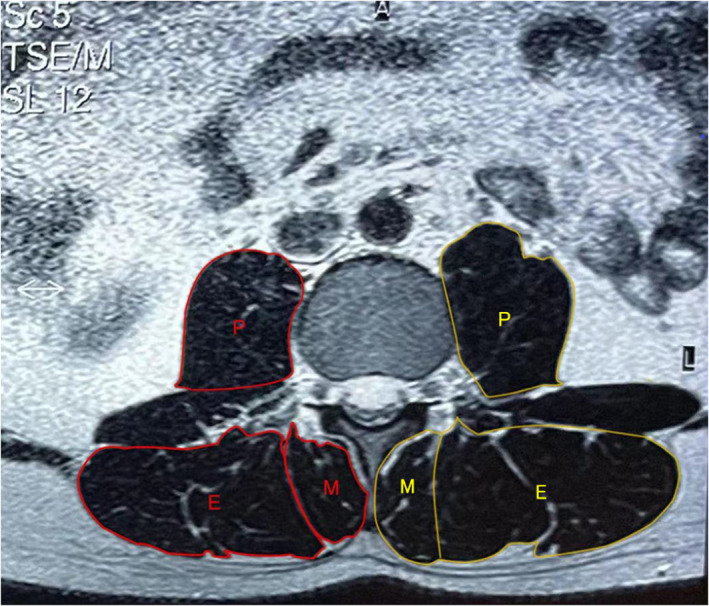

In [13]:
image

In [14]:
dataset[1]["caption"]

'Erector spinae (E), multifidus (M), and psoas muscles (P) were segmented separately on right and left sides on the axial slice at mid‐disc of L4–L5 and L5–S1 on T2‐weighted axial images. The above parameters were measured unilaterally. The red line area is functional CSA (F‐CSA), which represents fat‐free area, evaluated quantitively by excluding the signal of the deposits of intramuscular fat. The signal intensity can distinguish fat and muscle tissue in a different range. Based on this, the yellow line area is total CSA (T‐CSA), which represents the sum of CSA of interested three muscles.'

In [1]:
pip install nltk rouge

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
from unsloth import FastVisionModel
from datasets import load_dataset
from tqdm import tqdm
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# 1. 准备工作
# -------------------------------------------------------------------------

# 确保 NLTK 的分词器可用（如果报错，会自动下载轻量包）
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

# 加载模型
model_path = "./lora_model"  # 您的微调模型路径
print(f"正在加载模型: {model_path} ...")

model, tokenizer = FastVisionModel.from_pretrained(
    model_name = model_path,
    load_in_4bit = True,
    local_files_only = True # 强制只用本地文件
)
FastVisionModel.for_inference(model) # 开启推理模式

# 加载数据（建议测试集）
dataset = load_dataset("./dataSet/", split="train") 
# 为了演示，这里随机取 20 条，您跑通后可以把 [:20] 去掉跑全量
eval_dataset = dataset.select(range(20)) 

print(f"评估样本数: {len(eval_dataset)}")

# -------------------------------------------------------------------------
# 2. 推理生成 (Inference)
# -------------------------------------------------------------------------

references = []   # 真实标签
predictions = []  # 模型预测

instruction = "你是一名专业的放射科医生。请准确描述你在图片中看到的内容。"

print("正在生成报告...")
for i in tqdm(range(len(eval_dataset))):
    sample = eval_dataset[i]
    image = sample["image"]
    ground_truth = sample["caption"]
    
    # 构造输入
    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": instruction}
        ]}
    ]
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to("cuda")

    # 生成配置
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            use_cache=True,
            temperature=0.2, # 低温度增加确定性
            min_p=0.1
        )
    
    # 解码
    input_len = inputs.input_ids.shape[1]
    generated_text = tokenizer.decode(output_ids[0][input_len:], skip_special_tokens=True)
    
    predictions.append(generated_text.strip())
    references.append(ground_truth.strip())

# -------------------------------------------------------------------------
# 3. 计算指标 (BLEU & ROUGE)
# -------------------------------------------------------------------------

print("\n正在计算指标...")

bleu_scores = []
rouge = Rouge()
rouge_l_scores = []

# 平滑函数，防止短句子得分为0
chencherry = SmoothingFunction()

for ref, pred in zip(references, predictions):
    # --- 计算 BLEU-4 ---
    # 需要分词 (Tokenize)
    ref_tokens = nltk.word_tokenize(ref.lower())
    pred_tokens = nltk.word_tokenize(pred.lower())
    
    # weights=(0.25, 0.25, 0.25, 0.25) 表示 BLEU-4
    b_score = sentence_bleu([ref_tokens], pred_tokens, 
                           weights=(0.25, 0.25, 0.25, 0.25),
                           smoothing_function=chencherry.method1)
    bleu_scores.append(b_score)
    
    # --- 计算 ROUGE-L ---
    # 防止空字符串报错
    if len(pred) == 0: 
        rouge_l_scores.append(0.0)
        continue
        
    try:
        scores = rouge.get_scores(pred, ref)
        # 取 ROUGE-L 的 F1 分数
        rouge_l_scores.append(scores[0]['rouge-l']['f'])
    except Exception:
        rouge_l_scores.append(0.0)

# -------------------------------------------------------------------------
# 4. 结果展示与可视化
# -------------------------------------------------------------------------

avg_bleu = sum(bleu_scores) / len(bleu_scores)
avg_rouge = sum(rouge_l_scores) / len(rouge_l_scores)

print("\n" + "="*40)
print("             评估结果报告")
print("="*40)
print(f"BLEU-4  (精确度): {avg_bleu:.4f}")
print(f"ROUGE-L (召回率): {avg_rouge:.4f}")
print("="*40)

# 绘制分布图
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(bleu_scores, bins=10, color='skyblue', edgecolor='black')
plt.title('BLEU-4 Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(rouge_l_scores, bins=10, color='salmon', edgecolor='black')
plt.title('ROUGE-L Score Distribution')
plt.xlabel('Score')

plt.tight_layout()
plt.savefig('metrics_distribution.png')
plt.show()

# 保存详细数据
df = pd.DataFrame({
    'Ground Truth': references,
    'Prediction': predictions,
    'BLEU-4': bleu_scores,
    'ROUGE-L': rouge_l_scores
})
df.to_csv("final_evaluation.csv", index=False)
print("详细结果已保存至 final_evaluation.csv")